
# Monte Carlo Control for Blackjack (`Blackjack-v1`, Gymnasium)

Este notebook implementa un agente que aprende a jugar Blackjack usando **control por Monte Carlo on‑policy** con una política **ε-greedy**. Pasos:

1. Política inicial aleatoria (ε-greedy sobre `Q` inicial).
2. Simulación de episodios completos desde el inicio hasta un estado terminal.
3. Estimación de `Q(s, a)` con **first-visit MC**.
4. Mejora de política usando `argmax_a Q(s,a)` dentro de un esquema ε-greedy.
5. Medición del rendimiento promedio de la política final.
    

In [ ]:
import math
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym


In [12]:

# Crear entorno Blackjack-v1
env = gym.make("Blackjack-v1", sab=True)  # sab=True usa la versión compatible con Sutton & Barto
nA = 2  # acciones: 0=Stick, 1=Hit

# Semilla para reproducibilidad
seed = 42
rng = np.random.default_rng(seed)
env.reset(seed=seed)
    

((15, 2, 0), {})

In [13]:

def epsilon_greedy_action(Q, state, nA=2, epsilon=0.1, rng=None):
    """Devuelve una acción ε-greedy dada Q y el estado."""
    if rng is None:
        rng = np.random.default_rng()
    if rng.random() < epsilon:
        return rng.integers(nA)
    else:
        return int(np.argmax(Q[state]))
    

In [14]:

def generate_episode(env, Q, epsilon=0.1, rng=None):
    """Genera un episodio completo (s, a, r) usando política ε-greedy sobre Q."""
    if rng is None:
        rng = np.random.default_rng()
    episode = []
    state, info = env.reset()
    done = False
    while not done:
        action = epsilon_greedy_action(Q, state, nA=2, epsilon=epsilon, rng=rng)
        next_state, reward, terminated, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        done = terminated or truncated
    return episode
    

In [15]:

def mc_control_on_policy(num_episodes=50000, gamma=1.0, epsilon=0.1, seed=42, log_every=10000):
    """
    Control por Monte Carlo (first-visit) on-policy con ε-greedy.
    Devuelve: Q (defaultdict), política derivada (π*), historial de retornos medios.
    """
    rng = np.random.default_rng(seed)
    Q = defaultdict(lambda: np.zeros(2, dtype=float))
    returns_sum = defaultdict(lambda: np.zeros(2, dtype=float))
    returns_count = defaultdict(lambda: np.zeros(2, dtype=float))

    average_returns = []
    window = 2000
    recent_g = []

    for i in range(1, num_episodes + 1):
        episode = generate_episode(env, Q, epsilon=epsilon, rng=rng)

        # First-visit: registrar primeras ocurrencias por (s,a)
        sa_first_visit = set()
        G = 0.0
        # Retropropagar retornos
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            if (s, a) not in sa_first_visit:
                sa_first_visit.add((s, a))
                returns_sum[s][a] += G
                returns_count[s][a] += 1.0
                Q[s][a] = returns_sum[s][a] / max(1.0, returns_count[s][a])

        # Seguimiento de retorno del episodio para monitoreo
        episode_return = sum(r for (_, _, r) in episode)
        recent_g.append(episode_return)
        if len(recent_g) > window:
            recent_g.pop(0)

        if i % log_every == 0:
            avg = float(np.mean(recent_g)) if recent_g else 0.0
            average_returns.append((i, avg))
            print(f"Episodio {i}: retorno promedio (últimos {window}) = {avg:.4f}")

    # Política final determinista (greedy)
    def greedy_pi(state):
        return int(np.argmax(Q[state]))

    return Q, greedy_pi, np.array(average_returns)
    

In [16]:

# Entrenamiento (ajuste el número de episodios según su tiempo disponible)
NUM_EPISODES = 50000
EPSILON = 0.1
GAMMA = 1.0

Q, greedy_pi, monitor = mc_control_on_policy(num_episodes=NUM_EPISODES, gamma=GAMMA, epsilon=EPSILON, seed=seed, log_every=10000)
print("Entrenamiento completado.")
    

Episodio 10000: retorno promedio (últimos 2000) = -0.1410
Episodio 20000: retorno promedio (últimos 2000) = -0.1075
Episodio 30000: retorno promedio (últimos 2000) = -0.1480
Episodio 40000: retorno promedio (últimos 2000) = -0.0980
Episodio 50000: retorno promedio (últimos 2000) = -0.1275
Entrenamiento completado.


In [17]:

# Evaluación de la política aprendida
def evaluate_policy(env, policy_fn, episodes=10000, seed=123):
    rng = np.random.default_rng(seed)
    total_return = 0.0
    for _ in range(episodes):
        s, info = env.reset(seed=int(rng.integers(0, 10_000_000)))
        done = False
        G = 0.0
        while not done:
            a = policy_fn(s)
            s, r, terminated, truncated, info = env.step(a)
            G += r
            done = terminated or truncated
        total_return += G
    avg_return = total_return / episodes
    return avg_return

avg_return = evaluate_policy(env, greedy_pi, episodes=20000, seed=999)
print(f"Rendimiento promedio de la política final: {avg_return:.4f}")
    

Rendimiento promedio de la política final: -0.0802


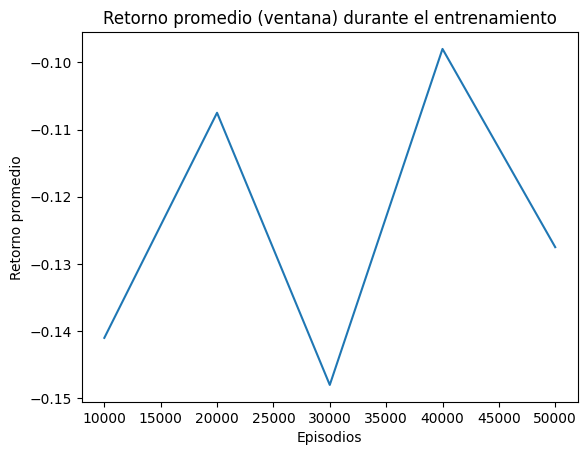

In [18]:

# Visualización básica (una figura por gráfico como se solicita)
# 1) Curva de aprendizaje: retorno promedio (ventana deslizante)
if monitor.size > 0:
    plt.figure()
    plt.plot(monitor[:,0], monitor[:,1])
    plt.title("Retorno promedio (ventana) durante el entrenamiento")
    plt.xlabel("Episodios")
    plt.ylabel("Retorno promedio")
    plt.show()
else:
    print("Sin datos de monitoreo suficientes para graficar.")
    

In [27]:

# 2) Mapa de políticas: para cada par (player sum, dealer showing), con o sin usable ace
# Estados: (player_sum in [12..21], dealer_showing in [1..10], usable_ace in {False, True})
import pandas as pd

def build_policy_grid(Q, usable_ace=False):
    rows = []
    for ps in range(12, 22):
        row = []
        for dealer in range(1, 11):
            s = (ps, dealer, usable_ace)
            a = int(np.argmax(Q[s])) if s in Q else 1  # por defecto: hit
            row.append(a)
        rows.append(row)
    df = pd.DataFrame(rows, index=list(range(12,22)), columns=list(range(1,11)))
    return df

pi_no_ace = build_policy_grid(Q, usable_ace=False)
pi_ace    = build_policy_grid(Q, usable_ace=True)

# Mostrar como tablas (0=Stick, 1=Hit)
print("Política (usable_ace=False) 0=Stick,1=Hit")
print(pi_no_ace)

print("\nPolítica (usable_ace=True) 0=Stick,1=Hit")
print(pi_ace)
    

Política (usable_ace=False) 0=Stick,1=Hit
    1   2   3   4   5   6   7   8   9   10
12   1   0   1   1   0   1   0   1   1   1
13   1   1   0   1   1   0   1   1   0   1
14   1   1   0   0   0   0   0   1   1   1
15   0   0   0   0   0   0   1   0   1   1
16   1   0   0   0   0   0   0   0   0   0
17   1   0   0   0   0   0   0   0   0   0
18   0   0   0   0   0   0   0   0   0   0
19   0   0   0   0   0   0   0   0   0   0
20   0   0   0   0   0   0   0   0   0   0
21   0   0   0   0   0   0   0   0   0   0

Política (usable_ace=True) 0=Stick,1=Hit
    1   2   3   4   5   6   7   8   9   10
12   0   1   0   1   0   0   1   1   1   1
13   1   0   1   0   0   1   1   1   1   0
14   1   0   1   1   0   1   1   1   1   1
15   0   1   1   0   0   0   1   1   0   1
16   0   1   1   1   0   1   0   1   1   0
17   1   0   1   0   1   1   1   1   1   1
18   0   1   0   1   0   1   0   0   0   1
19   0   1   0   1   0   0   0   0   0   0
20   0   0   0   0   1   0   0   0   0   0
21   0   0   

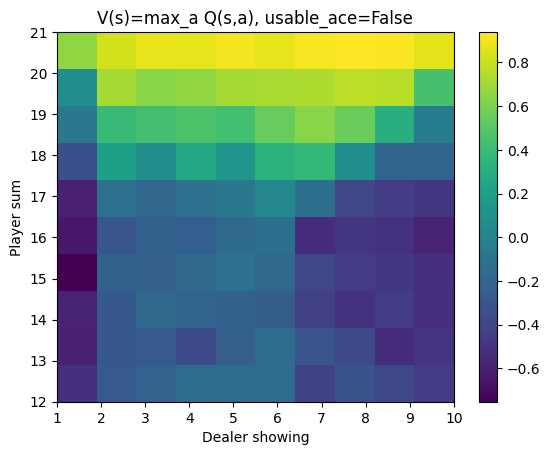

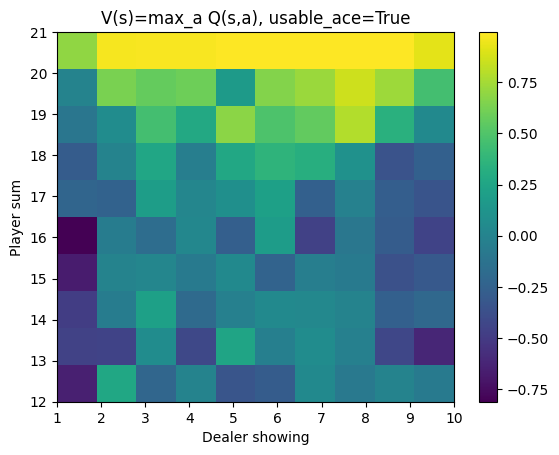

In [28]:

# 3) Heatmap de V(s) = max_a Q(s,a) para usable_ace=False/True
def build_value_grid(Q, usable_ace=False):
    grid = np.zeros((10,10))  # player_sum: 12..21 (10 valores), dealer: 1..10 (10 valores)
    for i, ps in enumerate(range(12,22)):
        for j, dealer in enumerate(range(1,11)):
            s = (ps, dealer, usable_ace)
            if s in Q:
                grid[i,j] = np.max(Q[s])
            else:
                grid[i,j] = 0.0
    return grid

V_no_ace = build_value_grid(Q, usable_ace=False)
V_ace    = build_value_grid(Q, usable_ace=True)

plt.figure()
plt.imshow(V_no_ace, origin="lower", extent=[1,10,12,21], aspect="auto")
plt.colorbar()
plt.title("V(s)=max_a Q(s,a), usable_ace=False")
plt.xlabel("Dealer showing")
plt.ylabel("Player sum")
plt.show()

plt.figure()
plt.imshow(V_ace, origin="lower", extent=[1,10,12,21], aspect="auto")
plt.colorbar()
plt.title("V(s)=max_a Q(s,a), usable_ace=True")
plt.xlabel("Dealer showing")
plt.ylabel("Player sum")
plt.show()
    

In [31]:

# Guardar objetos y utilidades
import pickle, os

out_dir = "./out'"
os.makedirs(out_dir, exist_ok=True)

with open(os.path.join(out_dir, "Q_blackjack_mc.pkl"), "wb") as f:
    pickle.dump(dict(Q), f)

# Guardar la política como función discreta (tabla)
pi_table = {k: int(np.argmax(v)) for k, v in Q.items()}
with open(os.path.join(out_dir, "policy_greedy_blackjack.pkl"), "wb") as f:
    pickle.dump(pi_table, f)

print("Archivos guardados en:", out_dir)
    

Archivos guardados en: ./out'
